In [3]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import io, os, time
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Prepare image

In [4]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.path = data.label
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path, label = self.data[index]
        fname = os.path.basename(img_path)
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, fname

In [5]:
test_path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train"
matches = []
for root, dirnames, filenames in os.walk(test_path):
    for filename in filenames:
        if filename.endswith(('.png', ".PNG")):
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

4117


In [4]:
df_test = pd.DataFrame(matches, columns = ["img_path"])
stage = df_test["img_path"].str.split("\\", expand = True)[8]
# df_test.loc[:, "stage"] = stage
df_test.loc[:, "label"] = 0
# df_test.loc[:, "ts"] = df_test.folder.apply(lambda x: int(x.split("D")[0][1:]))
df_test.head()

,img_path,label
0,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,0
1,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,0
2,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,0
3,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,0
4,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,0


In [6]:
df = pd.DataFrame(matches, columns = ["img_path"])

df.loc[:, "fname"] = df["img_path"].str.split("\\", expand = True)[8]
df.loc[:, "ts"] = df.fname.apply(lambda x: int(x.split("D")[0][1:]))

# create a list of our conditions
conditions = [
    (df['fname'].str.contains("un")), 
    (df['ts'] <= 12),
    (df['ts'] >= 14) & (df['ts'] <= 30),
#     (df['ts'] > 9) & (df['ts'] <= 15),
    (df['ts'] => 32)
    ]

# create a list of the values we want to assign for each condition
# values = ["un", 'ring', 'troph', 'shiz']
values = np.arange(4)
# create a new column and use np.select to assign values to it using our lists as arguments
df['label'] = np.select(conditions, values, default = np.nan)
df.head()

,img_path,fname,ts,label
0,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,T0D1_1102.png,0,1.0
1,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,T0D1_1115.png,0,1.0
2,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,T0D1_151.png,0,1.0
3,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,T0D1_170.png,0,1.0
4,C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMS...,T0D1_177.png,0,1.0


In [7]:
df_test = df

In [5]:
my_transforms = transforms.Compose([transforms.Resize((224, 224)),
#                                     transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        [0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])])
def transform_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

In [9]:
batch_size = 256
test_dataset =  MalariaDataset(df_test[["img_path", "label"]], my_transforms)               
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

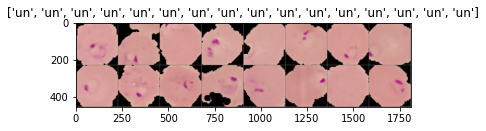

In [37]:
inputs, classes = next(iter(test_loader))
class_names = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load the model

In [12]:
class_names = ["un", 'ring', 'troph', 'shiz']

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    return class_names[y_hat]

In [13]:
# Load
PATH = r"resnet18_finetunl7.pth"
# model = torch.load(PATH, map_location = device)
model = torch.load(PATH)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# test-the-model
ls_df = []
all_preds = []
test_labels = []
since = time.time()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels, fnames) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.append(predicted)
        test_labels.append(labels)
        
        tmp_df = pd.DataFrame(zip(fnames, predicted.cpu().numpy()))
        ls_df.append(tmp_df)
        total += labels.size(0)
        correct += (predicted != labels).sum().item()
      
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 94.33880098708086 %
Training complete in 0m 31s


In [15]:
df_pred = pd.concat(ls_df)
df_pred.columns = ["fname", "pred"]
df_pred.head()

,fname,pred
0,C100P61ThinF_IMG_20150918_144104_cell_162.png,1
1,C100P61ThinF_IMG_20150918_144104_cell_163.png,2
2,C100P61ThinF_IMG_20150918_144104_cell_164.png,1
3,C100P61ThinF_IMG_20150918_144104_cell_165.png,1
4,C100P61ThinF_IMG_20150918_144104_cell_166.png,0


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 15.0, 'Predicted label')

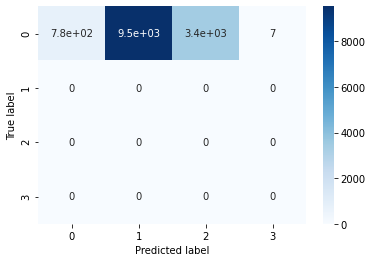

In [17]:
cm = confusion_matrix(torch.cat(test_labels).cpu(), torch.cat(all_preds).cpu())
sns.heatmap(cm, annot = True, cmap = "Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

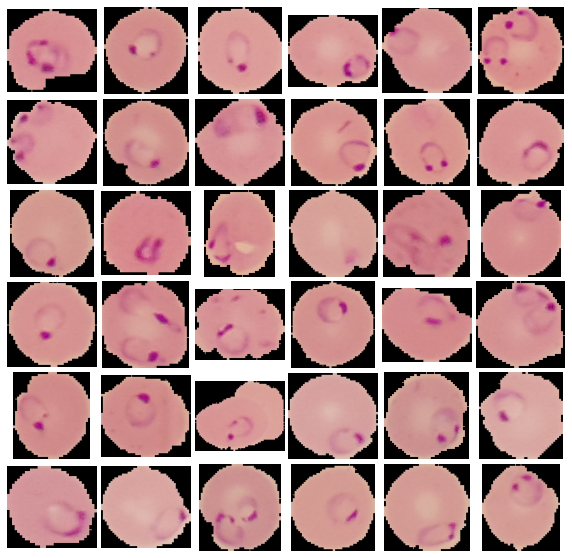

In [42]:
root_path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images\Parasitized"
img_ls = df_pred[df_pred.pred == 2].fname.values

fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
start = 20
for idx, val in enumerate(img_ls[start*36:start*36+36]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = plt.imread(os.path.join(root_path, val))
#     img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(im)

In [118]:
img_ls

array(['C100P61ThinF_IMG_20150918_144104_cell_166.png',
       'C100P61ThinF_IMG_20150918_144348_cell_142.png',
       'C100P61ThinF_IMG_20150918_144823_cell_158.png', ...,
       'C99P60ThinF_IMG_20150918_142334_cell_4.png',
       'C99P60ThinF_IMG_20150918_142334_cell_6.png',
       'C99P60ThinF_IMG_20150918_142334_cell_9.png'], dtype=object)